<a href="https://colab.research.google.com/github/minshyee/RecoSyS/blob/main/RecomSYS_using_Surprise_Package_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
!pip install scikit-surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#### surprise 기본 제공 DATASET
- ml-100k : movieLens 100k data
- ml-1m : movieLens 1m data(100만)
- jester : joke site post(650만)


### 사용가능한 알고리즘
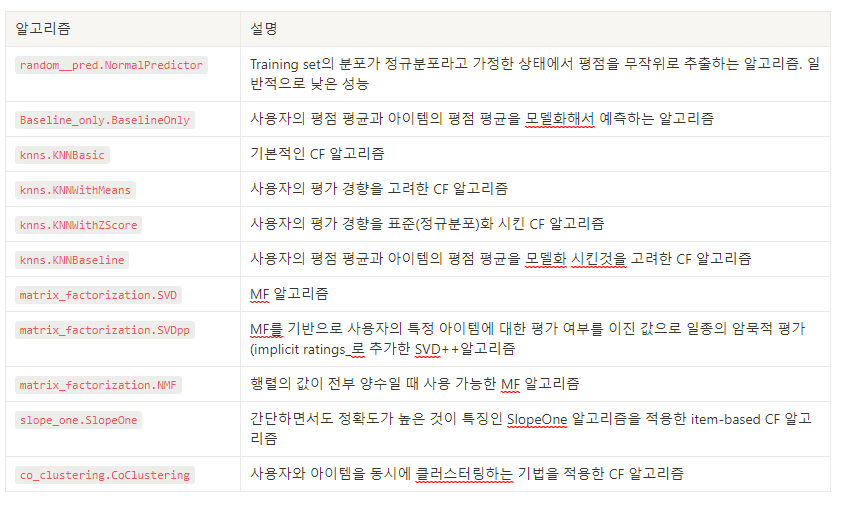



In [16]:
import numpy as np

from surprise import BaselineOnly, KNNWithMeans, SVD, SVDpp, Dataset, accuracy, Reader
from surprise.model_selection import cross_validate, train_test_split
import matplotlib.pyplot as plt


In [23]:
data = Dataset.load_builtin('ml-100k', prompt=False)

Trying to download dataset from http://files.grouplens.org/datasets/movielens/ml-100k.zip...
Done! Dataset ml-100k has been saved to /root/.surprise_data/ml-100k


In [24]:
# train test 분리
trainset, testset = train_test_split(data, test_size=0.25)

In [26]:
algo = KNNWithMeans()

algo.fit(trainset)

predictions = algo.test(testset)

accuracy.rmse(predictions)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9574


0.9573524268224938

## 알고리즘 비교

Estimating biases using als...
RMSE: 0.9488
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9574
RMSE: 0.9428
RMSE: 0.9251


array([0.92512294, 0.94283158, 0.94876984, 0.95735243])

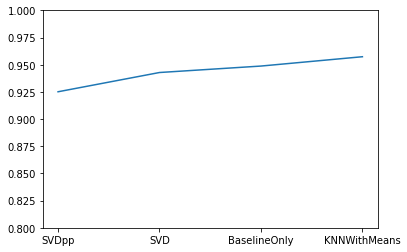

In [28]:
algorithms = [BaselineOnly, KNNWithMeans, SVD, SVDpp]

names = []
results = []

for opt in algorithms:
  algo = opt()
  names.append(opt.__name__)
  # train
  algo.fit(trainset)
  # predict
  predictions = algo.test(testset)
  # rmse 저장
  results.append(accuracy.rmse(predictions))
names = np.array(names)
results = np.array(results)

index = np.argsort(results) # result 값이 작은 순으로 index 추출
plt.ylim(0.8,1)
plt.plot(names[index], results[index])
results[index]

## 알고리즘 옵션 지정

In [30]:
sim_options = {'name':'pearson_baseline',
               'user_based' : True}
algo = KNNWithMeans(k=30, sim_options=sim_options)
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9451


0.9450776166044277

In [31]:
result = []
for neighbor_size in (10,20,30,40,50,60):
  algo = KNNWithMeans(k=neighbor_size,
                      sim_options = sim_options)
  algo.fit(trainset)
  predictions = algo.test(testset)
  result.append([neighbor_size, accuracy.rmse(predictions)])
result

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9582
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9473
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9451
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9453
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9453
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9455


[[10, 0.9581611966371654],
 [20, 0.9472799566991879],
 [30, 0.9450776166044277],
 [40, 0.9452977425380229],
 [50, 0.9453451281973967],
 [60, 0.9454670051167386]]

## 다양한 파라미터 비교


In [32]:
# GridSearch for KNN
from surprise.model_selection import GridSearchCV

param_grid = {
    'k' : [5,10,15,25],
    'sim_options':{
              'name':['pearson_baseline', 'cosine'],
              'user_based' : [True, False]}
}

gs = GridSearchCV(KNNWithMeans,
                  param_grid,
                  measures=['rmse'],
                  cv=4)
gs.fit(data)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similar

In [33]:
print(gs.best_score['rmse']) # 최적 RMSE
print(gs.best_params['rmse']) # 최적값의 parameter

0.9246936079294463
{'k': 25, 'sim_options': {'name': 'pearson_baseline', 'user_based': False}}


In [36]:
param_grid = {
    'n_epochs':[70,80,90],
    'lr_all':[0.005, 0.006, 0.007],
    'reg_all':[0.05, 0.07,0.1]
}

gs = GridSearchCV(algo_class = SVD,
                  param_grid=param_grid,
                  measures=['rmse'],
                  cv=4)
gs.fit(data)

print(gs.best_score['rmse']) # 최적 RMSE
print(gs.best_params['rmse']) # 최적값의 parameter

0.9126298191928132
{'n_epochs': 90, 'lr_all': 0.006, 'reg_all': 0.1}


### 외부 데이터 읽어오기

In [38]:
import os
import numpy as np
import pandas as pd

base_src = '/content/drive/MyDrive/Recosys/Data'

u_data_src = os.path.join(base_src, 'u.data')
r_cols = ['user_id','movie_id','rating','timestamp']

ratings = pd.read_csv(u_data_src,
                      sep='\t',
                      names=r_cols,
                      encoding='latin-1')

reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(ratings[['user_id', 'movie_id', 'rating']], reader)

In [39]:
data